# LENDING CLUB CASE STUDY 
## Group Members :
1. Karthick Chetti 
2. Anirudh KVC

## Objectives :
1. Reduce Credit loss from 'charged-off' customers who are the 'defaulters'. (Lending loans to ‘risky’ applicants) which is largest source of financial loss
2. Understand the driving factors (or driver variables) behind loan default

## Data Cleaning

### Task 1 : Removing the unnecessary columns based on its relevance to the objective

#### 1. id	& member_id are unique and shouldn't influence the loan_status
#### 2. emp_title - contains subjective information and irrevelant to analyze


### Task 2 : Format Correction of Columns

#### 1. term - remove months from each cell and convert to int

### Task 3 : Relevant Columns
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_length
home_ownership
annual_inc
verification_status
loan_status
purpose
addr_state
dti
delinq_2yrs
earliest_cr_line
mths_since_last_delinq
open_acc
pub_rec
revol_bal
revol_util
total_acc
last_pymnt_d
pub_rec_bankruptcies



In [189]:
#Load the libraryss
import pandas as pd #To work with dataset
pd.set_option("display.max_columns", 100)
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

In [164]:
#Importing data
lc_df=pd.read_csv("loan.csv")

C:\Users\user\Documents\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [165]:
#Looking at the data
lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,

In [166]:
#Understanding the data
lc_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

In [167]:
#Removing columns having 90% null values in them
lc_df_nulldrop=lc_df.dropna(axis=1,thresh=int(0.1*len(lc_df)))

In [168]:
#Printing number of columns removed
removed_columns=len(lc_df.columns)-len(lc_df_nulldrop.columns)
print(f"{removed_columns} columns were removed")

56 columns were removed


In [169]:
#Checking the statistics of the new dataframe
lc_df_nulldrop.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,39717.0,39717.0,39661.0,39717.0,39020.000000,39678.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,1.0,0.0,0.0,0.0,0.043260,0.0
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,0.0,0.0,0.0,0.0,0.204324,0.0
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,9.000000,0.000000,8850.000000,20.000000,0.000000,0.000000,9899.640319,9287.150000,8000.000000,1348.910000,0.000000,0.000000,0.000000,546.140000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
75%,8.377550e+05,1.047339e+06,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17058.000000,29.000000,0.000000,0.000000,16534.433040,15798.810000,13653.260000,2833.400000,0.000000,0.000000,0.000000,3293.160000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,0.0,1.0,0.0,0.0,0.0,2.000000,0.0


### It is observed that some columns have only one value(mostly 0) throughout the rows, which are not useful for the analysis

In [170]:
#Dropping such columns in the dataframe
dropped_col=[]
for col in lc_df_nulldrop.columns:
    if len(lc_df_nulldrop[col].unique())==1:
        dropped_col.append(col)
print(f"The columns to be dropped are : {dropped_col}")
lc_df_droppedcol=lc_df_nulldrop.drop(dropped_col,axis=1)

The columns to be dropped are : ['pymnt_plan', 'initial_list_status', 'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt']


### Dropping columns based on their relevance to the business objective
#### 1. id ,member id and url will be specific to each customer 
#### 2. title,emp_title,desc - Very subjective and unstructured values in these columns

In [171]:
#Collecting all non relevant columns
non_relevant_cols=["id","member_id","url","title","emp_title","desc"]
#Dropping these columns
lc_df_droppedcol.drop(non_relevant_cols,axis=1,inplace=True)

In [172]:
lc_df_droppedcol.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   39717 non-null  int64  
 1   funded_amnt                 39717 non-null  int64  
 2   funded_amnt_inv             39717 non-null  float64
 3   term                        39717 non-null  object 
 4   int_rate                    39717 non-null  object 
 5   installment                 39717 non-null  float64
 6   grade                       39717 non-null  object 
 7   sub_grade                   39717 non-null  object 
 8   emp_length                  38642 non-null  object 
 9   home_ownership              39717 non-null  object 
 10  annual_inc                  39717 non-null  float64
 11  verification_status         39717 non-null  object 
 12  issue_d                     39717 non-null  object 
 13  loan_status                 397

### It is observed that some columns still have missing values and 0 as only values in column
#### collections_12_mths_ex_med, chargeoff_within_12_mths, tax_liens

In [173]:
print("Unique values of collections_12_mths_ex_med column :",lc_df_droppedcol["collections_12_mths_ex_med"].unique())
print("Unique values of chargeoff_within_12_mths column :",lc_df_droppedcol["chargeoff_within_12_mths"].unique())
print("Unique values of tax_liens column :",lc_df_droppedcol["tax_liens"].unique())
#Hence, dropping these columns
lc_df_droppedcol.drop(["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens"],axis=1,inplace=True)

Unique values of collections_12_mths_ex_med column : [ 0. nan]
Unique values of chargeoff_within_12_mths column : [ 0. nan]
Unique values of tax_liens column : [ 0. nan]


In [174]:
lc_df_droppedcol.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,860xx,AZ,27.65,0,Jan-85,1,NaN,3,0,13648,83.70%,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,309xx,GA,1.00,0,Apr-99,5,NaN,3,0,1687,9.40%,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,606xx,IL,8.72,0,Nov-01,2,NaN,2,0,2956,98.50%,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,917xx,CA,20.00,0,Feb-96,1,35.0,10,0,5598,21%,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Dec-11,Current,other,972xx,OR,17.94,0,Jan-96,0,38.0,15,0,27783,53.90%,38,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


In [177]:
lc_df_droppedcol.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_length               38642 non-null  object 
 9   home_ownership           39717 non-null  object 
 10  annual_inc               39717 non-null  float64
 11  verification_status      39717 non-null  object 
 12  issue_d                  39717 non-null  object 
 13  loan_status              39717 non-null  object 
 14  purpose               

### There are still some columns which have missing values, Therefore understanding the number of missing values in these columns

In [175]:
empty_cols=lc_df_droppedcol.columns[lc_df_droppedcol.isna().any()].tolist()
empty_vals=[lc_df_droppedcol[col].isna().sum() for col in empty_cols]
empty_per_dict=dict(zip(empty_cols,empty_vals))
print("The missing values in each column is :\n",empty_per_dict)

The missing values in each column is :
 {'emp_length': 1075, 'mths_since_last_delinq': 25682, 'revol_util': 50, 'last_pymnt_d': 71, 'last_credit_pull_d': 2, 'pub_rec_bankruptcies': 697}


In [176]:
#Deleting columns which have significantly high missing values
lc_df_droppedcol.drop(["mths_since_last_delinq"],axis=1,inplace=True)

### Fixing data types of columns

In [183]:
#Removing % and converting to float
lc_df_droppedcol["int_rate"]=lc_df_droppedcol["int_rate"].str.replace("%","").astype(float)
lc_df_droppedcol["revol_util"]=lc_df_droppedcol["revol_util"].str.replace("%","").astype(float)

## Checking Outliers

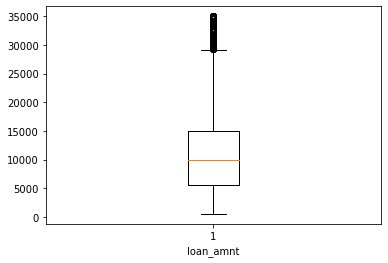

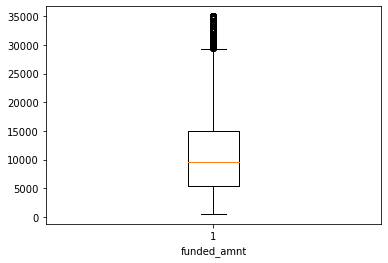

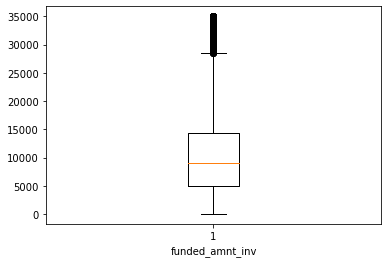

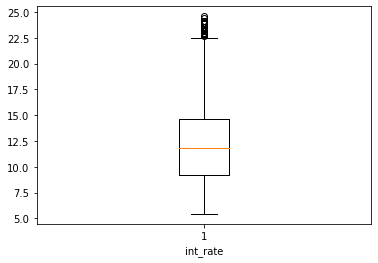

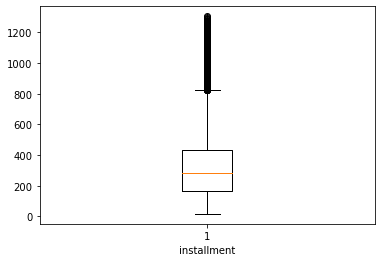

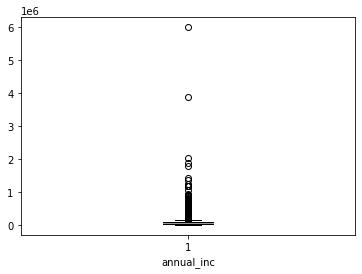

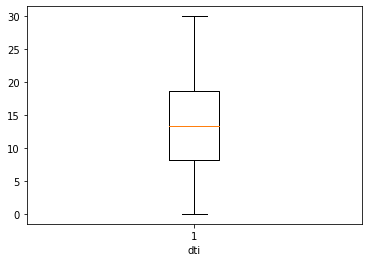

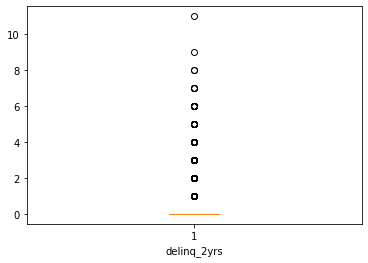

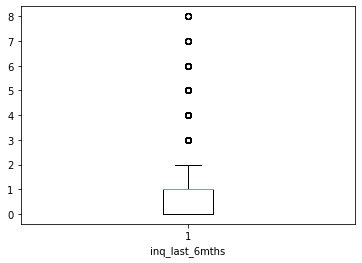

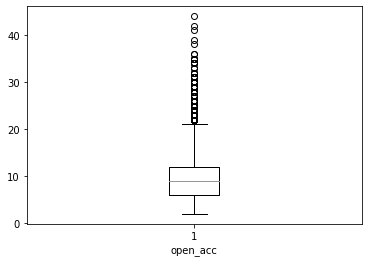

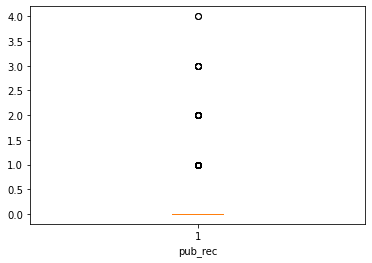

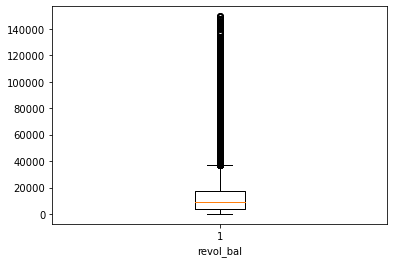

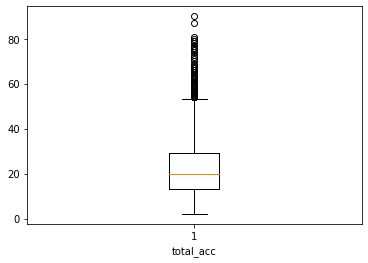

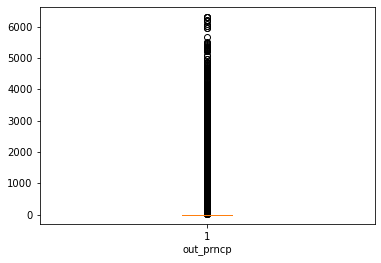

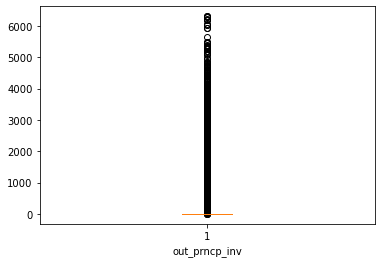

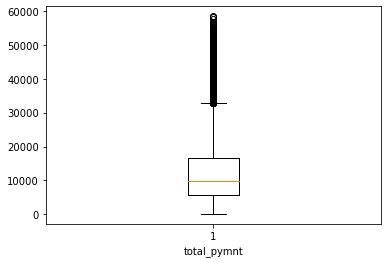

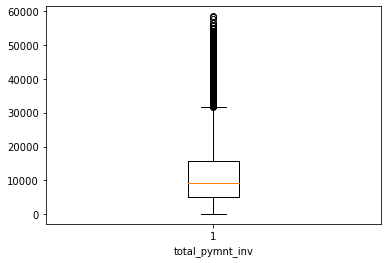

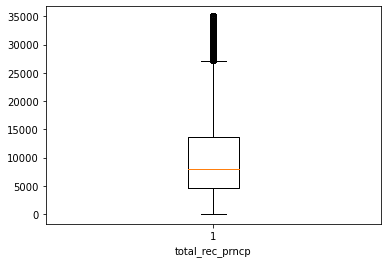

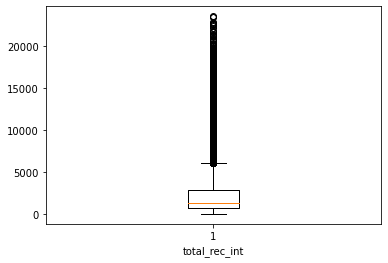

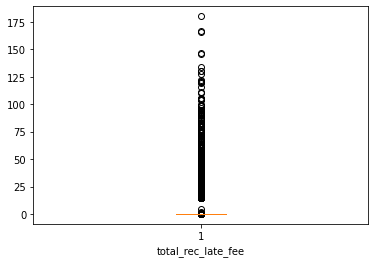

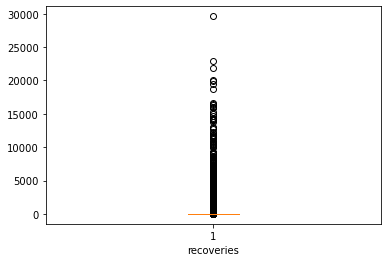

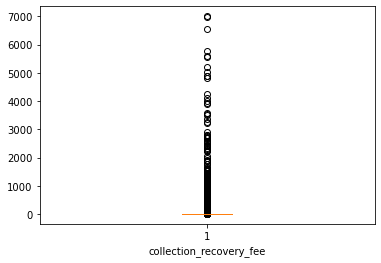

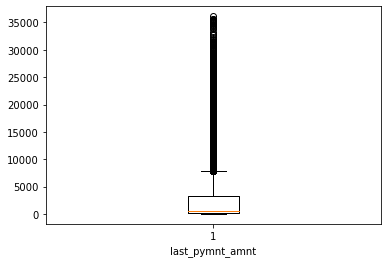

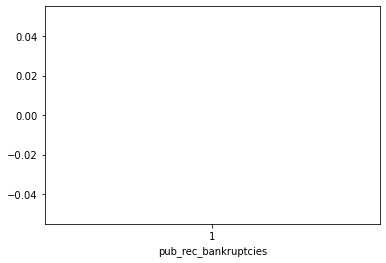

In [193]:
def box_plot_col(df):
    for col in df.columns:
        if df[col].dtype in ["int64","float64"]:
            plt.boxplot(df[col])
            plt.xlabel(col)
            plt.show()
box_plot_col(lc_df_droppedcol)

In [ ]:
### Derived Metrics
#### earliest_cr_line to year
#### closed acc = total - open acc
#### ratio of funded_amt_inv to loan_amt